**Date**: 2019-02-10

**Authors**: Adam Stafford, Zhanyuan Zhang

**Background**:
- Previously, we sampled the training data from the whole data set. We accidentally found out that different ways to perform the sampling led to different results. Specifically, for the same amount of data and the same bidirectional LSTM model, the validation accuracy tend to be higher (around ~80%) if we obtained the training data by randomly sampling from the first few species. However, did the sampling to the whole data set to get the training data, the model gave a lower validation accuracy (around 57%). 
- Our hypothesis is that sampling from whole dataset introduces noise into the training data, which prevent the model from improving. We may need biological reason to justify this noise.

**Purpose**: This experiment trained a bidirectional LSTM model on the first 30976 (out of 35976) data. By our hypothesis, this training set has less noise and thus the model should do a decent job. We wanted to see if the model's performance matched this expectation.

### Experiment:

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Load the `pickle` buffered list:

In [2]:
with open("../data/new_list_buffer.txt", "rb") as buff:
    seq_record_list = pickle.load(buff)

The following cell retains only 4800 sequences, for the purpose of testing speed. It also randomly shuffles the 4800 sequences.

In [3]:
print(len(seq_record_list))

35976


In [4]:
from random import shuffle
shuffle(seq_record_list)

In [5]:
# from random import shuffle
# shuffle(seq_record_list)
# seq_record_list = seq_record_list[:4800]

The following cell transforms the data into a format that is recognizable by the neural network model.

In [6]:
# A helper function to flatten a 2d list to 1d.
# Input: [[1, 2], [2, 3], [3, 4, 5]]
# Output: [1, 2, 2, 3, 3, 4, 5]
def flatten(lst):
    new_lst = []
    for sub_lst in lst:
        for item in sub_lst:
            new_lst.append(item)
    return new_lst

# A helper function to transform a lst so that its length becomes read_len by:
# 1. If len(lst) > read_len, curtail the end of the lst.
# 2. If len(lst) < read_len, keep extending the end of the lst with 0 (NA).
def curtail(lst, read_len):
    if len(lst) > read_len:
        lst = lst[:read_len]
    else:
        for i in range(read_len - len(lst)):
            lst.append([0, 0, 0, 0, 0, 0, 0, 0])
    return lst

# Produce the train-test split
# length_read: the length that you want all DNA sequences to conform to
def prepare_input(training_size, test_size, length_read):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    seq_count = 0
    while seq_count < training_size:
        X_train.append(flatten(curtail(seq_record_list[seq_count][3], length_read)))
        y_train.append(int(seq_record_list[seq_count][1]))
        seq_count += 1
    while seq_count < (training_size + test_size):
        X_test.append(flatten(curtail(seq_record_list[seq_count][3], length_read)))
        y_test.append(int(seq_record_list[seq_count][1]))
        seq_count += 1
    return X_train, y_train, X_test, y_test

# Turn list into numpy tensors that can directly feed into a neural network model
def to_np_array(X_train, y_train, X_test, y_test):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    if len(y_train.shape) == 1:
        y_train = np.transpose(np.array([y_train]))
    X_test = np.array(X_test)
    y_test = np.transpose(np.array(y_test))
    if len(y_test.shape) == 1:
        y_test = np.transpose(np.array([y_test]))
    return X_train, y_train, X_test, y_test

In [7]:
X_train, y_train, X_test, y_test = prepare_input(30976, 5000, 1000)
X_train, y_train, X_test, y_test = to_np_array(X_train, y_train, X_test, y_test)
[X_train.shape, y_train.shape, X_test.shape, y_test.shape]

[(30976, 8000), (30976, 1), (5000, 8000), (5000, 1)]

The following cells build a recurrent network with one bidirectional LSTM layer.

In [8]:
from keras.models import Model, Sequential
from keras.layers import Dense, CuDNNLSTM, Bidirectional

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
X_train_rnn = X_train.reshape(30976, 1000, 8)

In [10]:
model = Sequential()
#model.add(CuDNNLSTM(8, input_shape=(1000, 8), return_sequences=True))
model.add(Bidirectional(CuDNNLSTM(8), input_shape=(1000, 8)))
#model.add(CuDNNLSTM(8, return_sequences=True))
#model.add(CuDNNLSTM(4, return_sequences=True))
#model.add(CuDNNLSTM(4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_rnn, y_train, epochs=500, batch_size=128, validation_split=0.1)

Train on 27878 samples, validate on 3098 samples
Epoch 1/500
27878/27878 [==============================] - 137s 5ms/step - loss: 0.6833 - acc: 0.5396 - val_loss: 0.6814 - val_acc: 0.5546
Epoch 2/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.6747 - acc: 0.5594 - val_loss: 0.6758 - val_acc: 0.5742
Epoch 3/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.6722 - acc: 0.5681 - val_loss: 0.6730 - val_acc: 0.5755
Epoch 4/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.6701 - acc: 0.5733 - val_loss: 0.6734 - val_acc: 0.5646
Epoch 5/500
27878/27878 [==============================] - 35s 1ms/step - loss: 0.6683 - acc: 0.5751 - val_loss: 0.6690 - val_acc: 0.5794
Epoch 6/500
27878/27878 [==============================] - 34s 1ms/step - loss: 0.6662 - acc: 0.5822 - val_loss: 0.6668 - val_acc: 0.5865
Epoch 7/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.6637 - acc: 0.5891 - val_loss: 0.6662 - 

Epoch 118/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.5595 - acc: 0.7145 - val_loss: 0.5974 - val_acc: 0.6888
Epoch 119/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.5598 - acc: 0.7175 - val_loss: 0.5979 - val_acc: 0.6898
Epoch 120/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.5582 - acc: 0.7157 - val_loss: 0.6042 - val_acc: 0.6827
Epoch 121/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.5569 - acc: 0.7173 - val_loss: 0.6001 - val_acc: 0.6830
Epoch 122/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.5575 - acc: 0.7169 - val_loss: 0.5965 - val_acc: 0.6908
Epoch 123/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.5569 - acc: 0.7185 - val_loss: 0.5958 - val_acc: 0.6904
Epoch 124/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.5563 - acc: 0.7204 - val_loss: 0.6012 - val_acc: 0.6843
Epoch 125/500
27878/

27878/27878 [==============================] - 36s 1ms/step - loss: 0.5221 - acc: 0.7470 - val_loss: 0.5922 - val_acc: 0.7056
Epoch 235/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.5226 - acc: 0.7448 - val_loss: 0.5859 - val_acc: 0.6992
Epoch 236/500
27878/27878 [==============================] - 37s 1ms/step - loss: 0.5267 - acc: 0.7420 - val_loss: 0.5894 - val_acc: 0.6979
Epoch 237/500
27878/27878 [==============================] - 37s 1ms/step - loss: 0.5242 - acc: 0.7476 - val_loss: 0.5902 - val_acc: 0.7005
Epoch 238/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.5232 - acc: 0.7456 - val_loss: 0.5815 - val_acc: 0.7101
Epoch 239/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.5231 - acc: 0.7453 - val_loss: 0.5908 - val_acc: 0.6975
Epoch 240/500
27878/27878 [==============================] - 37s 1ms/step - loss: 0.5222 - acc: 0.7453 - val_loss: 0.5908 - val_acc: 0.6969
Epoch 241/500
27878/27878 [=======

27878/27878 [==============================] - 36s 1ms/step - loss: 0.5080 - acc: 0.7548 - val_loss: 0.5785 - val_acc: 0.7143
Epoch 351/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.5068 - acc: 0.7571 - val_loss: 0.5725 - val_acc: 0.7192
Epoch 352/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.5071 - acc: 0.7564 - val_loss: 0.5762 - val_acc: 0.7150
Epoch 353/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.5057 - acc: 0.7576 - val_loss: 0.5733 - val_acc: 0.7163
Epoch 354/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.5083 - acc: 0.7544 - val_loss: 0.5790 - val_acc: 0.7169
Epoch 355/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.5038 - acc: 0.7593 - val_loss: 0.5833 - val_acc: 0.7108
Epoch 356/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.5069 - acc: 0.7570 - val_loss: 0.5827 - val_acc: 0.7069
Epoch 357/500
27878/27878 [=======

27878/27878 [==============================] - 36s 1ms/step - loss: 0.5001 - acc: 0.7607 - val_loss: 0.5883 - val_acc: 0.7098
Epoch 467/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.4989 - acc: 0.7612 - val_loss: 0.5752 - val_acc: 0.7224
Epoch 468/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.4973 - acc: 0.7620 - val_loss: 0.5732 - val_acc: 0.7169
Epoch 469/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.4980 - acc: 0.7628 - val_loss: 0.5725 - val_acc: 0.7208
Epoch 470/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.5004 - acc: 0.7605 - val_loss: 0.5803 - val_acc: 0.7234
Epoch 471/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.4992 - acc: 0.7610 - val_loss: 0.5675 - val_acc: 0.7260
Epoch 472/500
27878/27878 [==============================] - 36s 1ms/step - loss: 0.4978 - acc: 0.7620 - val_loss: 0.5713 - val_acc: 0.7198
Epoch 473/500
27878/27878 [=======

**Result**:

The following cell **visualize** the training/validation accuracies and losses over each epoch.

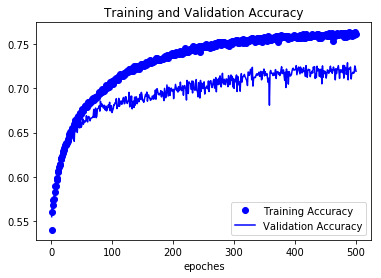

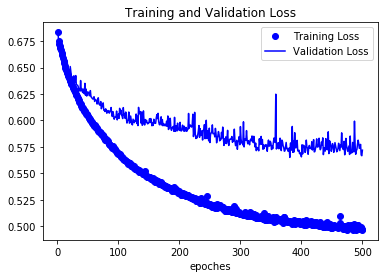

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoches')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoches')
plt.legend()

plt.show()

In [12]:
import utility
utility.save_model(model, 'models/adam_2019_01_29.json', 'models/adam_2019_01_29_weights.h5')


Save model to models/adam_2019_01_29.json


In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from utility import load_model
import pickle

# False Discovery Rate
This cell uses the model to make predictions on our data.

Then it iterates through the results and the real labels and compares them to check for False Positives(FP) and True Positives(TP).

Then it uses the formula to calculate the False Discovery Rate (FDR)

In [14]:
X_test_fdr = X_test.reshape(5000, 1000, 8)
results = model.predict(X_test_fdr, batch_size=16)

false_positives = 0
true_positives = 0
total_negatives = 0
total_positives = 0
true_negatives = 0

for i in range(0,results.size):
    
    if results[i][0]>=0.5 and y_test[i]==0:
        false_positives += 1

    if results[i][0]>=0.5 and y_test[i]==1:
        true_positives += 1
        
    if results[i][0]<=0.5 and y_test[i]==0:
        true_negatives += 1
        
    if results[i][0] <= 0.5:
        total_negatives += 1
        
    if results[i][0] >= 0.5:
        total_positives += 1

false_discovery_rate = false_positives/(false_positives + true_positives)
print("The false discovery rate is: {}".format(false_discovery_rate))

The false discovery rate is: 0.30776173285198555


# C-statistics
This cell iterates through the data using an incrementing threshold value to generate an ROC Curve then uses a Riemann sum (trapezoidal) to generate the C-statistic

ROC Curve


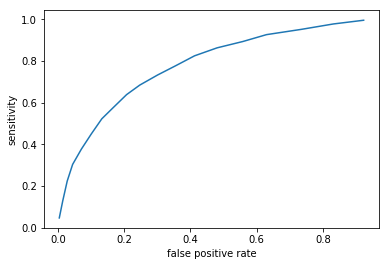

c-statistic = 0.7120263907710906


In [16]:
sensitivities = []
false_positive_rates =[]
discovery_percentage = 0.05

while discovery_percentage < 1.0:
    
    false_positives = 0
    true_positives = 0
    total_negatives = 0
    total_positives = 0
    true_negatives = 0
    
    for i in range(0,results.size):

        if results[i][0]>=discovery_percentage and y_test[i]==0:
            false_positives += 1

        if results[i][0]>=discovery_percentage and y_test[i]==1:
            true_positives += 1

        if results[i][0]<=discovery_percentage and y_test[i]==0:
            true_negatives += 1

        if y_test[i]==0:
            total_negatives += 1

        if y_test[i]==1:
            total_positives += 1
            
    if total_positives != 0 and total_negatives != 0:
        sensitivities.append(true_positives / total_positives)
        false_positive_rates.append(1-(true_negatives / total_negatives))
    
    discovery_percentage += 0.05
    
riemann = 0.0
for i in range(0,len(sensitivities) - 1):
    riemann += 0.5 * (sensitivities[i]+sensitivities[i+1]) * (false_positive_rates[i]-false_positive_rates[i+1])
    

print("ROC Curve")
plt.plot(false_positive_rates, sensitivities )
plt.ylabel('sensitivity')
plt.xlabel('false positive rate')
plt.show()
print("c-statistic = " + str(riemann))

#### c-statistic > 0.7 indicates that this is a good model

### Conclusion:

- The FDR and C-statistic showed us that the model did a decent job, which matches our expectation.
- Hence, the hypothesis is reasonable and we need to investigate further to figure out the reason.

### Next:

- Increase the number of epochs to see if the validation accuracy can be improved.
- Use RELU instead of Sigmoid to prevent the gradient-vanishing issue.
- Evaluate the model on new Drosophila species.